In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [45]:
data = pd.read_csv('SPY.csv', index_col=0)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,adj_factor,Adj Open,Adj High,Adj Low,Amount,Return
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4939.000000
mean,154.916778,155.806689,153.932967,154.915397,130.080000,1.131555e+08,0.812321,130.078555,130.806185,129.273872,1.670164e+10,0.000215
std,55.392654,55.455574,55.300664,55.399593,61.369875,9.924321e+07,0.090854,61.360605,61.498516,61.191653,1.263130e+10,0.012023
min,67.949997,70.000000,67.099998,68.110001,53.947025,1.436600e+06,0.680423,53.820293,55.444013,53.147048,2.102599e+08,-0.103637
25%,115.087498,115.914999,114.237499,115.035000,86.590834,4.774008e+07,0.729271,86.563831,87.135411,85.990860,5.662622e+09,-0.004688
50%,135.365005,136.359375,134.345001,135.367500,104.276886,8.471245e+07,0.806054,104.382847,105.009414,103.567459,1.585927e+10,0.000637
75%,194.987495,195.797501,193.922504,194.922497,174.989334,1.524191e+08,0.892026,174.750644,175.675158,173.599633,2.352806e+10,0.005786
max,301.880005,302.230011,300.850006,302.010010,296.099121,8.710263e+08,0.980428,295.971668,296.314816,294.961829,9.561302e+10,0.135577


In [46]:
def series_to_supervised(data, lags=10, columns=None, burnout=100):
    """
    Create  X: a 3D array, in shape (nsample, lags, nfeatures)
            Y: a 2D array, in shape (nsample, 1)
    """
    if not columns:
        columns = ['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'Amount']
    nsample, nfeatures = len(data), len(columns)
    
    Y = data['Return'].values
    X = np.zeros((nsample, lags, nfeatures))
    for i in range(1, lags+1):
        X[:, lags-i, :] = data[columns].shift(i).values
    
    return X[lags+burnout:], Y[lags+burnout:]

def normalize_X(X, data, lags=10, burnout=100, window=50):
    """
    This part will normalize features in X.
    To normalize the prices, we will calculate the ratio of price to the close of lag+1 day before
    To normalize the amount, we will calculate the ratio of amount to its 50 days' rolling average
    args:
        X: feature data
        data: the price&volume dataframe
        window: the window for the rolling average
    return:
        normalized X
    """
    price_o = data['Adj Close'].shift(lags + 1).values[lags+burnout:].reshape(-1, 1, 1)
    avg_amt = data['Amount'].rolling(window).mean().shift(1).values[lags+burnout:].reshape(-1, 1)
    
    X[:, :, :-1] = X[:, :, :-1] / price_o # normalize the prices
    X[:, :, -1] = X[:, :, -1] / avg_amt # normalize the amount
    
    return X

def normalize_y(Y):
    """
    Apply robust scaler to Y and Clip the extremums of Y.
    return:
        y: normalized version
    """
    scaler = RobustScaler()
    scaler.fit(Y.reshape(-1,1))
    Y[Y > scaler.center_ + 2.5*scaler.scale_] = scaler.center_ + 2.5*scaler.scale_
    Y[Y < scaler.center_ - 2.5*scaler.scale_] = scaler.center_ - 2.5*scaler.scale_
    return Y * 100

def Prepare_data(data, lags=10, columns=None, burnout=100, window=50, train_size=2000):
    """
    A wrapper for data preparation.
    """
    X, Y = series_to_supervised(data, lags, columns, burnout)
    X = normalize_X(X, data, lags, burnout, window)
    train_label, test_label = Y[:train_size], Y[train_size:]*100
    train_label = normalize_y(train_label)
    cache = {
        'train_data': X[:train_size],
        'train_label': train_label,
        'test_data': X[train_size:],
        'test_label': test_label
#         'scaler': scaler
    }
    return cache

In [47]:
nlags = 20

cache = Prepare_data(data, 20, train_size=-1200)

In [48]:
import keras.backend as K
def right_direction(y_true, y_pred):
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  fig, ax = plt.subplots()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('MSE')
  ax.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  ax.legend()
  ax1 = ax.twinx()
  ax1.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error', color='r')
#   plt.ylim([0,])
  ax1.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy', color='r')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()

def build_model1(units=12, nlags=10, seed=1):
    
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=False, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
#         layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.Dense(10, activation='relu'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

def build_model(units=12, nlags=10, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=True, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [49]:
initial_epoch=0
tf.random.set_seed(0)
model = build_model1(nlags=nlags)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12)                864       
_________________________________________________________________
dropout_5 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                130       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10)                40        
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

Epoch 1/2
181/181 [==============================] - 5s 26ms/step - loss: 1.3278 - right_direction: 52.5599 - mae: 0.8605 - val_loss: 0.5638 - val_right_direction: 46.0870 - val_mae: 0.5712
Epoch 2/2
181/181 [==============================] - 5s 26ms/step - loss: 1.3216 - right_direction: 53.9710 - mae: 0.8585 - val_loss: 0.5528 - val_right_direction: 49.7645 - val_mae: 0.5602
7


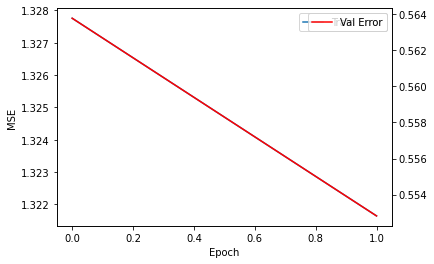

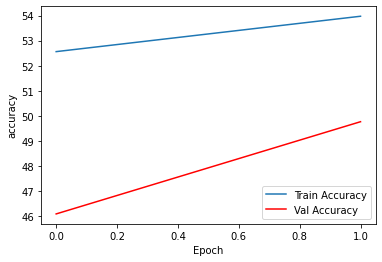

In [52]:
train_data = cache['train_data']
train_label = cache['train_label']

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 2
tf.random.set_seed(1)
history = model.fit(
    train_data, train_label, batch_size=16, shuffle=False ,epochs=EPOCHS, validation_split=0.2, 
    verbose=1, callbacks=[PrintDot()])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history)

In [23]:
# model.load_weights('../Weights/weights01')

In [16]:
length = int(len(cache['train_label']) * 0.8)
np.var(cache['train_label'][:length])

1.3343695469124586

(1200,) (1200,)


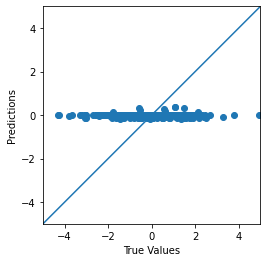

In [41]:
test_data = cache['test_data']
test_labels = cache['test_label']
test_predictions = model.predict(test_data).flatten()
print(test_labels.shape, test_predictions.shape)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.plot([-5, 5], [-5, 5])


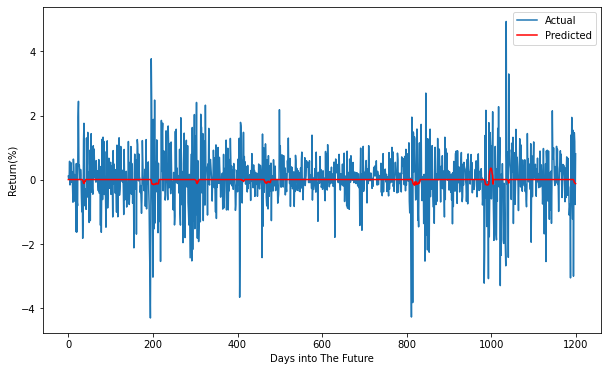

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', c='r')
plt.ylabel("Return(%)")
plt.xlabel('Days into The Future')
plt.legend()
plt.show()

In [36]:
def test_signal(y_pre, threshold=1):
    flag_p = y_pre > threshold
    flag_n = y_pre < -threshold
    return (flag_p, flag_n)

def stra_performance(flag_n, flag_p, ret_23, start_num=2000, end_num=3000, label='long-short', mode='test'):
    stra_ret = np.zeros(len(ret_23))
    # flag = (trends[11] > 0) & (trends[11]<5)
    # flag_1 = (trends_1[11] < 0) & (trends_1[11]>-5)
    dates = range(len(ret_23))
    flag_p = flag_p.squeeze()
    flag_n = flag_n.squeeze()
    stra_ret[flag_n] = ret_23[flag_n]
    stra_ret[flag_p] = -ret_23[flag_p]
    earnings  = [0]
    count_trades = np.count_nonzero(stra_ret)
    print(label, ": ")
    print("# of trading：", count_trades, ";   winning rate：", np.count_nonzero(stra_ret > 0) / count_trades)
    for i in range(len(stra_ret)):
        earnings.append(stra_ret[i] + earnings[-1])
    tdays = stra_ret != 0
    print("return per trade：", earnings[-1] / count_trades, "; Sharpe：", np.mean(stra_ret[tdays]) / np.std(stra_ret[tdays])*np.sqrt(242))
    plt.plot(earnings, label="Sharpe Ratio = {:.4}".format(np.mean(stra_ret[tdays]) / np.std(stra_ret[tdays])*np.sqrt(242)))
    plt.xlabel("Dates")
    K = int((end_num - start_num) / 5)
    plt.legend()
    plt.ylabel("Return")
    plt.title("Return on {} set".format(mode))
    plt.show()
    
def back_test(start_num=0, end_num=2000, threshold=0.5, mode='test'):
    test_data = cache[mode+'_data'][start_num:end_num]
    test_labels = cache[mode+'_label'][start_num:end_num]
    test_predictions = model.predict(test_data).flatten()
    flag_p, flag_n = test_signal(test_predictions, threshold)
    stra_performance(flag_p, flag_n, test_labels/100, start_num, end_num, mode=mode)
    
    

long-short : 
# of trading： 706 ;   winning rate： 0.5750708215297451
return per trade： 0.0006910369288667266 ; Sharpe： 0.7869524833225091


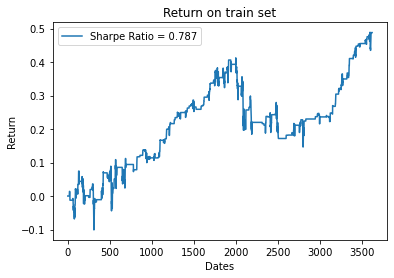

In [54]:
back_test(start_num=0, end_num=4000, threshold=0.1, mode='train')

In [43]:
model.evaluate(cache['test_data'], cache['test_label'])

38/38 [==============================] - 0s 6ms/step - loss: 0.7392 - right_direction: 52.7324 - mae: 0.5886


[0.7391960024833679, 52.73238754272461, 0.588574230670929]

In [32]:
np.mean(cache['test_label']**2), np.mean(np.abs(cache['test_label']))

(0.7384102489302866, 0.5886320700033613)

In [383]:
dirpath = '../Weights'
if os.path.exists(dirpath):
    os.makedirs(dirpath)
filename = 'weights01'
model.save_weights(os.path.join(dirpath, filename))

In [62]:
len(cache['test_data'][:2500])

2320

In [457]:
def build_model2(units=12, nlags=10, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
        layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
        layers.BatchNormalization(trainable=True),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=True, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [458]:
initial_epoch=0
tf.random.set_seed(0)
model2 = build_model2(nlags=nlags)
model2.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 20, 8)             48        
_________________________________________________________________
dense_152 (Dense)            (None, 20, 12)            108       
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 12)            48        
_________________________________________________________________
dense_153 (Dense)            (None, 20, 12)            156       
_________________________________________________________________
lstm_60 (LSTM)               (None, 20, 12)            1200      
_________________________________________________________________
dropout_48 (Dropout)         (None, 20, 12)            0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 12)              


....................................................................................................
....................................................................................................
....................................................................................................900


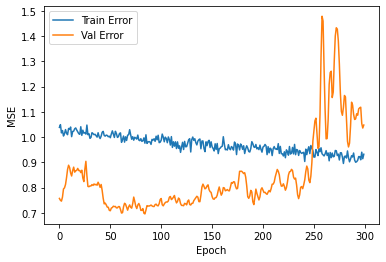

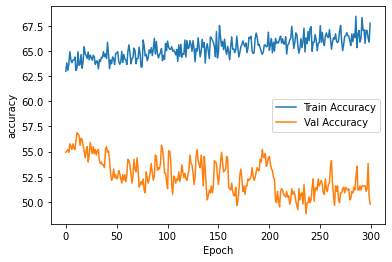

In [464]:
EPOCHS = 300
tf.random.set_seed(1)
history2 = model2.fit(
    train_data, train_label, batch_size=2048, shuffle=False ,epochs=EPOCHS, validation_split=0.2, 
    verbose=0, callbacks=[PrintDot()])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history2)

In [465]:
model2.evaluate(cache['train_data'][:2896], cache['train_label'][:2896])

91/91 [==============================] - 1s 13ms/step - loss: 1.4099 - right_direction: 57.5328 - mae: 0.8674


[1.4099003076553345, 57.53279113769531, 0.8673699498176575]

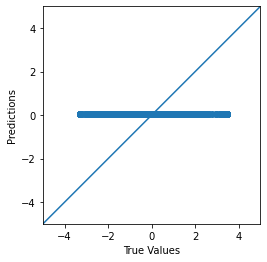

In [443]:
test_data = cache['train_data'][:1000]
test_labels = cache['train_label'][:1000]
test_predictions = model2.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.plot([-5, 5], [-5, 5])

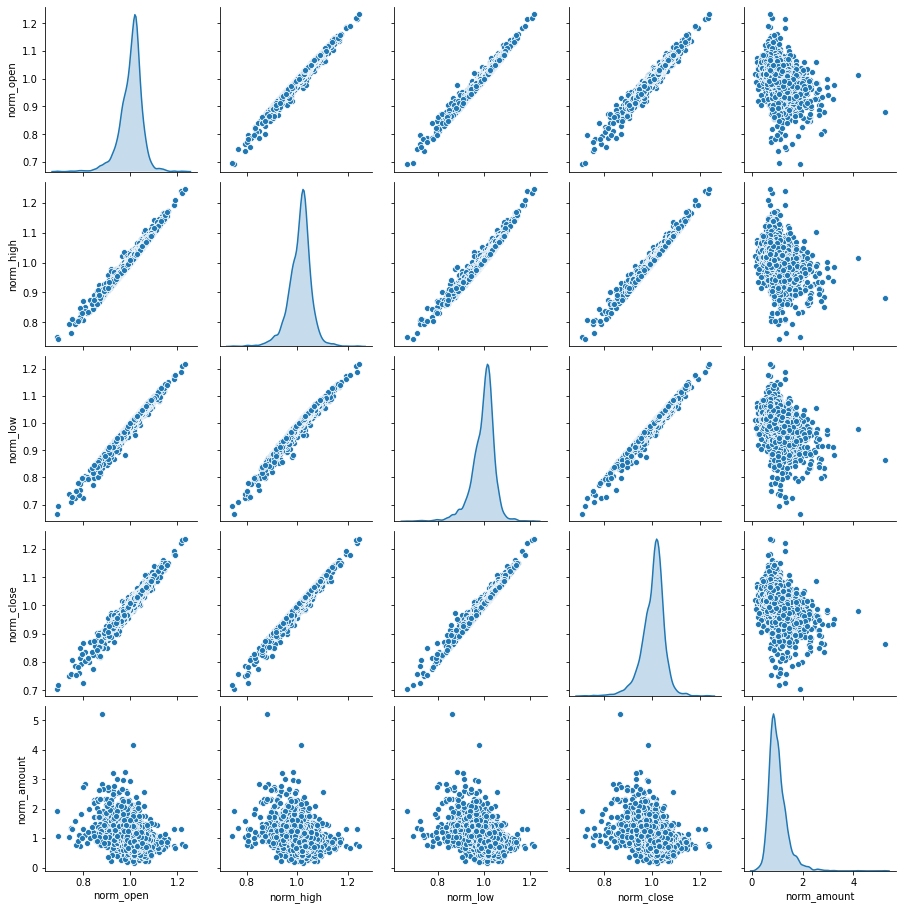

In [19]:
features = pd.DataFrame(cache['train_data'][:,19,:], columns=['norm_'+i for i in ['open','high','low','close','amount']])
sns.pairplot(features, diag_kind="kde")

In [30]:
s = RobustScaler()
s.fit(np.random.randn(100000,1))
s.scale_

array([1.35131942])